# son-analyze & service's metrics within son-emu
___

`son-analyze` can fetch metrics from VNFs running in `son-emu` with the help of the `son-monitor` component.
In this notebook, we suppose that:
* `son-analyze`, `son-emu` & `son-monitor` run on the same host
* A service is currently running under `son-emu`
* `son-monitor` has been started
* A `msd` file has been push to `son-monitor` to monitor the VNF `empty_vnf1`


## Setup
We import various packages related to SONATA. 

In [1]:
import son_analyze
import son_scikit

The `helpers.py` file is located in the parent folder.

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
import helpers

## Fetching metrics from the SONATA's emulator
Some imports are necessary to use `son-analyze` & `son-scikit`.

In [3]:
import json
import arrow
import requests
from son_analyze.core.prometheus import PrometheusData
from son_scikit.hl_prometheus import build_sonata_df_by_id

* `query` is the base Prometheus filter. It targets the `soemu_rx_count_packets` metric for network interface `output` of the vnf `empty_vnf1`
* `start` & `end` are two timestamp representing a time range. This range will delimit the time window for the queried metrics
 * `end` is the current time
 * `start` is `3` minutes in the past
* `payload` is the request body, it has a `1` secode time step
* `req` is the actual request to fetch the metrics:
 * `172.17.0.1` is the ip of the docker interface on the host

In [4]:
query = 'sonemu_rx_count_packets{vnf_name="empty_vnf1",vnf_interface="output"}'
end = arrow.utcnow()
print('The current date is: {}'.format(end))
start = end.replace(minutes=-3)
payload = {'query': query, 'start': start.timestamp, 'end': end.timestamp, 'step': '1s'}
req = requests.get('http://172.17.0.1:9090/api/v1/query_range?',
                   params=payload)

_x = PrometheusData(json.dumps(req.json()))
all_dataframes = build_sonata_df_by_id(_x)

The current date is: 2017-09-01T15:47:03.783386+00:00


/opt/conda/lib/python3.6/site-packages/arrow/arrow.py:417: DeprecationWarning: replace() with plural property to shift valueis deprecated, use shift() instead
  DeprecationWarning)


Each VNF has its own dataframe where metrics have a corresponding column. Here, the `empty_vnf1` VNF has a `sonemu_rx_count_packets` column for the monitored received packets on the network.

In [5]:
display(all_dataframes['empty_vnf1'].head())

,sonemu_rx_count_packets
2017-09-01 15:44:03+00:00,621.0
2017-09-01 15:44:04+00:00,623.0
2017-09-01 15:44:05+00:00,624.0
2017-09-01 15:44:06+00:00,625.0
2017-09-01 15:44:07+00:00,627.0


## Basic plotting with metrics from son-emu
From there we use the `df` and `ddf` variables as shortcuts, before plotting them.
* `df` is the main dataframe we are going to work with
* `ddf` contains the discrete difference of `df`

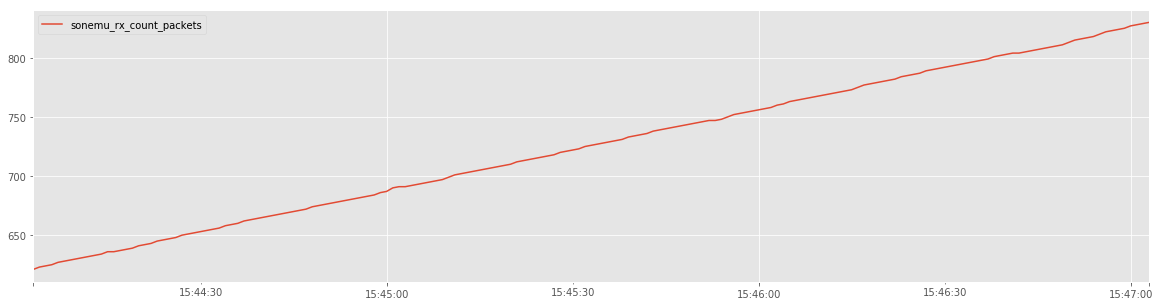

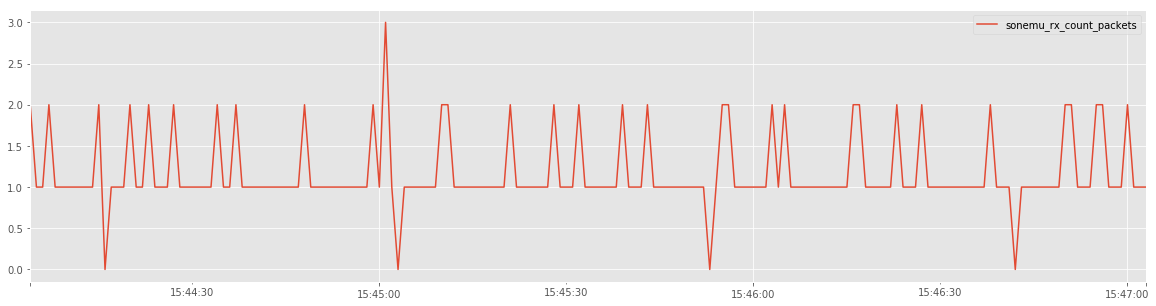

In [6]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)

df = all_dataframes['empty_vnf1']
ddf = df.diff().dropna()

df.plot();
ddf.plot();